In [1]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import sys
sys.path.append("../src")
from ensemble import Ensemble
DATA = Path("../data")
BUSINESS = DATA / "business.json"
USER = DATA / "user.json"
REVIEW = DATA / "review.json"
SAVEPATH = DATA / "yelp.csv"
YELP = DATA / "yelp_v2.csv"

# Helper functions

In [2]:
from sklearn.ensemble import BaggingRegressor, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
import scikitplot as sklplt

def measure(label:str, X_train, X_test, y_train, y_test, classifier):
    clf = classifier()
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    
    ax = sklplt.metrics.plot_roc_curve(y_test, y_prob)
    ax.get_legend().remove()
    ax.figure.legend(loc='lower left', # mode='expand', 
               ncol=1,
               bbox_to_anchor=(0.1, 1.04))

    savefig(label+"_roc", ax=ax)
    ax2 = sklplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    low, high = ax2.get_ylim()
    ax2.set_ylim([low+0.5, high-0.5])
    plt.grid(b=None)
    savefig(label+"_conf", ax=ax2)
    
    ax3 = sklplt.metrics.plot_precision_recall(y_test, y_prob)
    ax3.get_legend().remove()
    ax3.figure.legend(loc='lower left', # mode='expand', 
               ncol=1,
               bbox_to_anchor=(0.1, 1.04))
    savefig(label+"_precrec", ax=ax3)
    if len(y_test.unique()) == 2:
        ax4 = sklplt.metrics.plot_calibration_curve(y_test, [y_prob])
        savefig(label+"_calib", ax=ax4)
    
    ax5 = sklplt.metrics.plot_lift_curve(y_test, y_prob)
    savefig(label+"lift", ax=ax5)
    return ax


#with plt.style.context("ggplot"):
#    traintest = train_test_split(X, y, test_size=0.3, random_state=1)
    #ax = measure(*traintest, RandomForestClassifier)
    #ax = measure(*traintest, ExtraTreesClassifier)
    #ax = measure(*traintest, AdaBoostClassifier)
    #ax.get_legend().remove()

In [3]:
def savefig(name, ax=None):
    if ax is None:
        plt.savefig("../figures/"+name+".png", dpi=200, transparent=True, bbox_inches='tight')
    else:
        ax.figure.savefig("../figures/"+name+".png", dpi=200, transparent=True, bbox_inches='tight')

# Preprocess the data 

In [4]:
from sklearn.preprocessing import StandardScaler
df = pd.read_csv(YELP)
# Don't know how to handle postal codes
df.drop(columns=['postal_code'], inplace=True)
for col in df.columns:
    un = df[col].unique()
    # Standardize all non-categorical variables
    if len(un) <= 3 or col in ['RestaurantsPriceRange2', 'stars', 'rating']:
        continue
    #print(col, len(un))
    df[col] = StandardScaler().fit_transform(df[col].to_numpy().reshape(-1, 1))

In [6]:
df['rating_tri'] = df['rating'].replace({1: "1", 2: "2,3,4", 3: "2,3,4", 4: "2,3,4", 5: "5"})
df['rating_tri_un'] = df['rating'].replace({3: 2, 4: 2, 5: 3})

In [8]:
X = df[:10_000].drop(columns=['rating', 'rating_tri', 'rating_tri_un'])
y_all = df[:10_000]['rating']
y_tri = df[:10_000]['rating_tri']
y_tri_un = df[:10_000]['rating_tri_un']

X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X, y_tri, test_size=0.3, stratify=y_all, random_state=1)
traintest_binary = X_bin_train, X_bin_test, y_bin_train, y_bin_test

# Explore the data

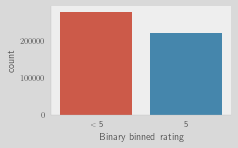

In [98]:
with plt.style.context("rapport"):
    ax = sns.countplot(x='rating', data=df)
    ax.set_xlabel("Rating")
    savefig("rating")
    
    ax = sns.countplot(x='rating_tri', data=df)
    ax.set_xlabel("Triary binned rating")
    savefig("rating_tri")
    
    ax = sns.countplot(x='rating_bin', data=df)
    ax.set_xlabel("Binary binned rating")
    savefig("rating_bin")

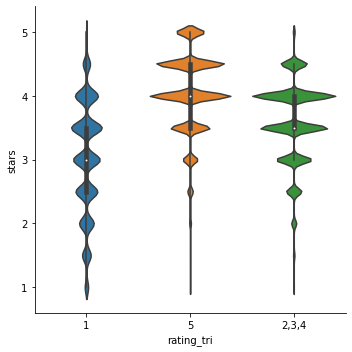

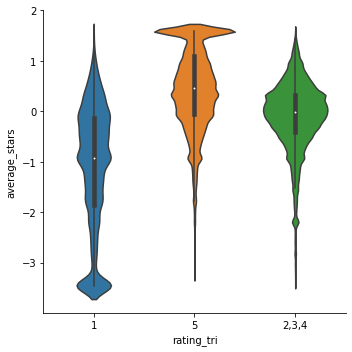

In [11]:
sns.catplot(x='rating_tri', y='stars', data=df, kind='violin')
sns.catplot(x='rating_tri', y='average_stars', data=df, kind='violin')

In [33]:
sns.distplot(df['time'])

NameError: name 'stats' is not defined

# Logistic Regression (Baseline)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y_bin, random_state=1)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.7461902214491891
0.7467976744341279


Tune hyperparameter and decompose into bias and variance for L2 penalty

In [82]:
ensemble = Ensemble(X, y_bin_un, num_members=50)
hyperparameters = np.logspace(-5, 2, num=20)
ensemble.run(lambda x: LogisticRegression(penalty='l2', C=1/x), hyperparameters)

In [86]:
with plt.style.context("rapport"):
    _, ax = ensemble.plot_train_test()
    savefig("logreg_bootstrap", ax=ax)
    _, ax = ensemble.plot_decomposition()
    savefig("logreg_biasvar", ax=ax)
    _, ax = ensemble.plot_coeffs()
    savefig("logreg_params", ax=ax)

(20, 50)


RuntimeError: latex was not able to process the following string:
b'$\\\\mathdefault{10^{-4}}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/erdos/.cache/matplotlib/tex.cache/c15cd063daf5f8c1461c25e5b922b47b.tex
LaTeX2e <2019-10-01> patch level 1
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/08/27 v1.4j Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./c15cd063daf5f8c1461c25e5b922b47b.aux)
(/usr/share/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \mathdefault 
                             
l.14 ...000000}{10.000000}{\sffamily $\mathdefault
                                                  {10^{-4}}$}
No pages of output.
Transcript written on c15cd063daf5f8c1461c25e5b922b47b.log.




<Figure size 232.229x143.525 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'$\\\\mathdefault{10^{-4}}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/erdos/.cache/matplotlib/tex.cache/c15cd063daf5f8c1461c25e5b922b47b.tex
LaTeX2e <2019-10-01> patch level 1
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/08/27 v1.4j Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./c15cd063daf5f8c1461c25e5b922b47b.aux)
(/usr/share/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \mathdefault 
                             
l.14 ...000000}{10.000000}{\sffamily $\mathdefault
                                                  {10^{-4}}$}
No pages of output.
Transcript written on c15cd063daf5f8c1461c25e5b922b47b.log.




<Figure size 232.229x143.525 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'$\\\\mathdefault{10^{-4}}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/erdos/.cache/matplotlib/tex.cache/c15cd063daf5f8c1461c25e5b922b47b.tex
LaTeX2e <2019-10-01> patch level 1
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/08/27 v1.4j Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./c15cd063daf5f8c1461c25e5b922b47b.aux)
(/usr/share/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \mathdefault 
                             
l.14 ...000000}{10.000000}{\sffamily $\mathdefault
                                                  {10^{-4}}$}
No pages of output.
Transcript written on c15cd063daf5f8c1461c25e5b922b47b.log.




<Figure size 232.229x143.525 with 1 Axes>

In [88]:
ensemble = Ensemble(X, y_bin_un, num_members=50)
hyperparameters = np.logspace(-5, 2, num=20)
ensemble.run(lambda x: LogisticRegression(penalty='l1', C=1/x, solver='saga'), hyperparameters)

In [96]:
with plt.style.context("rapport"):
    _, ax = ensemble.plot_train_test()
    savefig("logreg_bootstrap_l1", ax=ax)
    _, ax = ensemble.plot_decomposition()
    savefig("logreg_biasvar_l1", ax=ax)
    _, ax = ensemble.plot_coeffs()
    savefig("logreg_params_l1", ax=ax)

(20, 50)


RuntimeError: latex was not able to process the following string:
b'$\\\\mathdefault{10^{-4}}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/erdos/.cache/matplotlib/tex.cache/c15cd063daf5f8c1461c25e5b922b47b.tex
LaTeX2e <2019-10-01> patch level 1
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/08/27 v1.4j Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./c15cd063daf5f8c1461c25e5b922b47b.aux)
(/usr/share/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \mathdefault 
                             
l.14 ...000000}{10.000000}{\sffamily $\mathdefault
                                                  {10^{-4}}$}
No pages of output.
Transcript written on c15cd063daf5f8c1461c25e5b922b47b.log.




<Figure size 232.229x143.525 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'$\\\\mathdefault{10^{-4}}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/erdos/.cache/matplotlib/tex.cache/c15cd063daf5f8c1461c25e5b922b47b.tex
LaTeX2e <2019-10-01> patch level 1
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/08/27 v1.4j Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./c15cd063daf5f8c1461c25e5b922b47b.aux)
(/usr/share/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \mathdefault 
                             
l.14 ...000000}{10.000000}{\sffamily $\mathdefault
                                                  {10^{-4}}$}
No pages of output.
Transcript written on c15cd063daf5f8c1461c25e5b922b47b.log.




<Figure size 232.229x143.525 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'$\\\\mathdefault{10^{-4}}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/erdos/.cache/matplotlib/tex.cache/c15cd063daf5f8c1461c25e5b922b47b.tex
LaTeX2e <2019-10-01> patch level 1
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/08/27 v1.4j Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./c15cd063daf5f8c1461c25e5b922b47b.aux)
(/usr/share/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \mathdefault 
                             
l.14 ...000000}{10.000000}{\sffamily $\mathdefault
                                                  {10^{-4}}$}
No pages of output.
Transcript written on c15cd063daf5f8c1461c25e5b922b47b.log.




<Figure size 232.229x143.525 with 1 Axes>

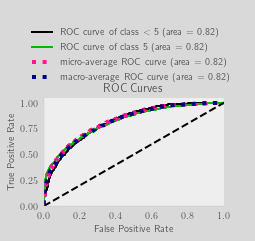

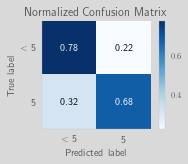

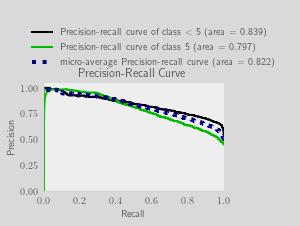

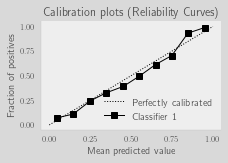

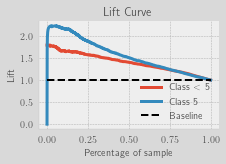

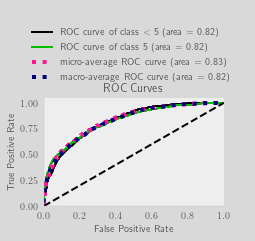

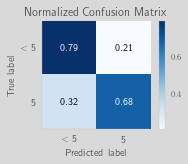

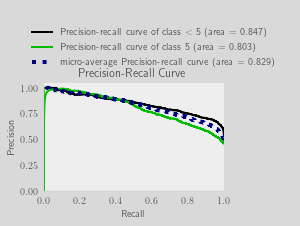

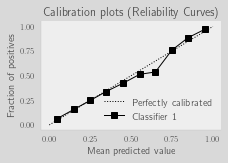

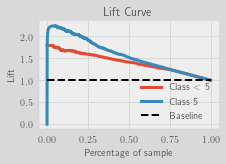

In [42]:
with plt.style.context("rapport"):
    measure("logreg_l1", *traintest_binary, lambda: LogisticRegression(penalty='l1', solver='saga'))
with plt.style.context("rapport"):
    measure("logreg_l2", *traintest_binary, lambda: LogisticRegression(penalty='l2'))

## Decision Trees

In [70]:
from sklearn import tree

In [75]:
X = df.drop(columns=['rating'])
y = df['rating']# >= 5.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [76]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9999914178069064
0.4592191598859912


In [74]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9999971392689688
0.6834520368726346


## Dimension Reduction

In [77]:
from sklearn.feature_selection import SelectKBest, chi2

In [78]:
Xnew = SelectKBest(chi2, k=2).fit_transform(X_train, y_train)

ValueError: Input X must be non-negative.

# Ensemble Methods

## Random Forest

In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [77]:
clf = RandomForestClassifier(n_estimators=20)
clf = clf.fit(X_bin_train, y_bin_train)
print(clf.score(X_bin_train, y_bin_train))
print(clf.score(X_bin_test, y_bin_test))

0.997
0.7333333333333333


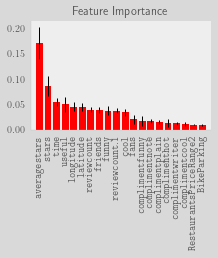

In [90]:
with plt.style.context("rapport"):
    names = ["$\mathtt{"+str(x).replace("_", " ") +"}$" for x in X_bin_train.columns]
    sklplt.estimators.plot_feature_importances(clf, feature_names=names,
                                              x_tick_rotation=90)
    savefig("randforest_feature_importance")

'd2ck'

In [51]:
ensemble = Ensemble(X, y_bin_un, num_members=50)
hyperparameters = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]
ensemble.run(lambda x: RandomForestClassifier(n_estimators=x), hyperparameters)

(12, 50)


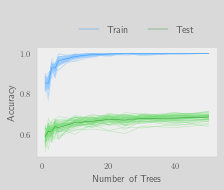

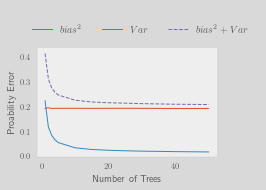

In [52]:
with plt.style.context("rapport"):
    _, ax = ensemble.plot_train_test()
    ax.set_xscale("linear")
    ax.set_xlabel("Number of Trees")
    savefig("randforest_bootstrap", ax=ax)
    _, ax = ensemble.plot_decomposition()
    ax.set_xscale("linear")
    ax.set_xlabel("Number of Trees")
    savefig("randforest_biasvar", ax=ax)

In [54]:
ensemble = Ensemble(X, y_bin_un, num_members=50)
hyperparameters = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]
ensemble.run(lambda x: RandomForestClassifier(n_estimators=20, max_depth=x), hyperparameters)

(12, 50)


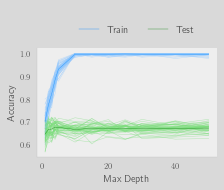

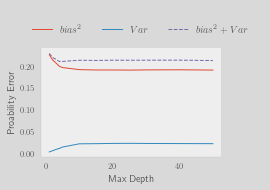

In [55]:
with plt.style.context("rapport"):
    _, ax = ensemble.plot_train_test()
    ax.set_xscale("linear")
    ax.set_xlabel("Max Depth")
    savefig("randforest_depth_bootstrap", ax=ax)
    _, ax = ensemble.plot_decomposition()
    ax.set_xscale("linear")
    ax.set_xlabel("Max Depth")
    savefig("randforest_depth_biasvar", ax=ax)

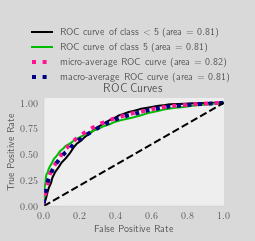

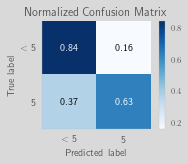

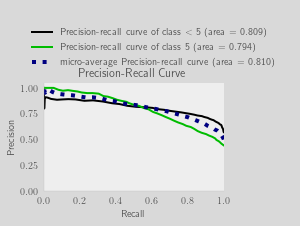

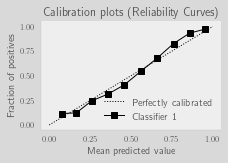

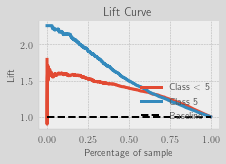

In [57]:
with plt.style.context("rapport"):
    measure("randforest", *traintest_binary, lambda: RandomForestClassifier(n_estimators=50))


## Extremely Randomized Trees

In [222]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import scikitplot as sklplt

In [227]:
X = df.drop(columns=['rating'])
y = df['rating']# >= 5.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [230]:
clf = ExtraTreesClassifier(n_estimators = 10)
clf.fit(X_train, y_train)
probas = clf.predict_proba(X_test)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9999914178069064
0.5054434528378712


0.7910463593859712
[2.   1.   0.9  0.8  0.7  0.6  0.5  0.45 0.4  0.3  0.25 0.2  0.15 0.1
 0.  ]


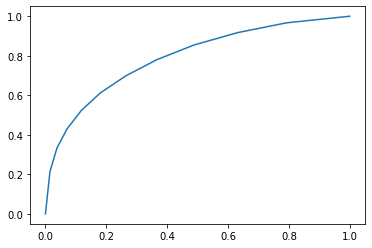

In [220]:
FP, TP, thresh = roc_curve(y_test, probas[:, 1])
roc_auc = auc(FP, TP)
print(roc_auc)
print(thresh)
plt.plot(FP, TP)

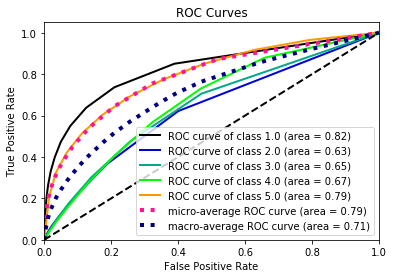

In [231]:
sklplt.metrics.plot_roc(y_test, probas)

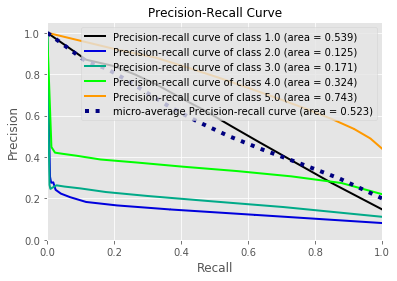

In [243]:
with plt.style.context('ggplot'):
    ax = sklplt.metrics.plot_precision_recall_curve(y_test, probas)

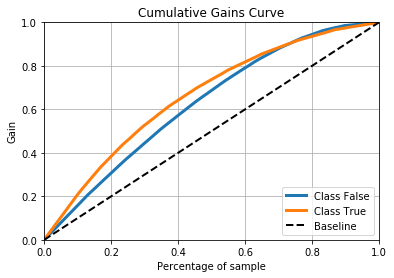

In [225]:
sklplt.metrics.plot_cumulative_gain(y_test, clf.predict_proba(X_test))

In [100]:
extra_train = []
extra_test = []
N_estimators = list(range(1, 20))
for n_estimators in tqdm(N_estimators):
    clf = ExtraTreesClassifier(n_estimators=n_estimators)
    clf = clf.fit(X_train, y_train)
    extra_train.append(clf.score(X_train, y_train))
    extra_test.append(clf.score(X_test, y_test))

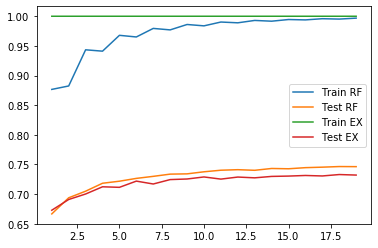

In [101]:
plt.plot(N_estimators, train, label='Train RF')
plt.plot(N_estimators, test, label='Test RF')
plt.plot(N_estimators, extra_train, label='Train EX')
plt.plot(N_estimators, extra_test, label='Test EX')
plt.legend()

Feature ranking:
1. average_stars 0.18656325354930842
2. stars 0.0884664549464527
3. time 0.07472648665382915
4. useful 0.06316165784672169
5. friends 0.053658119961149386
6. cool 0.05322773938356912
7. funny 0.052541223248244166
8. fans 0.03364736303060011
9. compliment_plain 0.03048886918471767
10. compliment_note 0.02921618097647651
11. compliment_writer 0.0227059281021783
12. compliment_cool 0.021088410133570334
13. compliment_funny 0.021068846849878448
14. compliment_hot 0.019360448797177663
15. compliment_more 0.01813806913499121
16. longitude 0.01708764327570498
17. latitude 0.017052361036021264
18. review_count.1 0.016960398667777165
19. review_count 0.016889668150590984
20. compliment_photos 0.016655027409853935
21. compliment_profile 0.01039204526290687
22. compliment_cute 0.009207492195005936
23. RestaurantsPriceRange2 0.006465451841919635
24. compliment_list 0.005607917052038169
25. WheelchairAccessible 0.0055899823269658444
26. Caters 0.005198127342804492
27. BusinessAccep

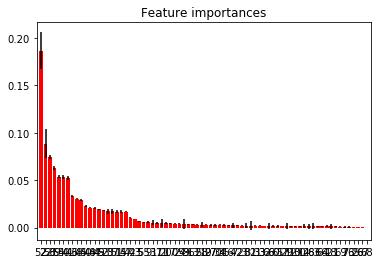

In [104]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print(f"{f+1}. {df.columns[indices[f]]} {importances[indices[f]]}")
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## AdaBoost

In [58]:
from sklearn.ensemble import AdaBoostClassifier
import scikitplot as sklplt

In [92]:
clf = AdaBoostClassifier(n_estimators=50, learning_rate=0.1)
clf.fit(X_bin_train, y_bin_train)
proba = clf.predict_proba(X_bin_test)
print(clf.score(X_bin_train, y_bin_train))
print(clf.score(X_bin_test, y_bin_test))

0.7491428571428571
0.756


In [60]:
ensemble = Ensemble(X, y_bin_un, num_members=50)
hyperparameters = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]
ensemble.run(lambda x: AdaBoostClassifier(n_estimators=x), hyperparameters)

(12, 50)


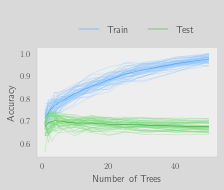

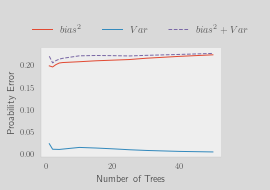

In [61]:
with plt.style.context("rapport"):
    _, ax = ensemble.plot_train_test()
    ax.set_xscale("linear")
    ax.set_xlabel("Number of Trees")
    savefig("ada_bootstrap", ax=ax)
    _, ax = ensemble.plot_decomposition()
    ax.set_xscale("linear")
    ax.set_xlabel("Number of Trees")
    savefig("ada_biasvar", ax=ax)

In [63]:
ensemble = Ensemble(X, y_bin_un, num_members=50)
hyperparameters = [2, 1, 0.9, 0.8, 0.5, 0.2, 0.1, 0.05, 0.01, 0.001, 0.001]
ensemble.run(lambda x: AdaBoostClassifier(n_estimators=20, learning_rate=x), hyperparameters)

In [64]:
with plt.style.context("rapport"):
    _, ax = ensemble.plot_train_test()
    ax.set_xlabel("Learning Rate")
    savefig("ada_lr_bootstrap", ax=ax)
    _, ax = ensemble.plot_decomposition()
    ax.set_xlabel("Learning Rate")
    savefig("ada_lr_biasvar", ax=ax)

(11, 50)


RuntimeError: latex was not able to process the following string:
b'$\\\\mathdefault{10^{-3}}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/erdos/.cache/matplotlib/tex.cache/bdc501ab6a67539d4fa3174217ca57ee.tex
LaTeX2e <2019-10-01> patch level 1
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/08/27 v1.4j Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file bdc501ab6a67539d4fa3174217ca57ee.aux.
(/usr/share/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \mathdefault 
                             
l.14 ...000000}{10.000000}{\sffamily $\mathdefault
                                                  {10^{-3}}$}
No pages of output.
Transcript written on bdc501ab6a67539d4fa3174217ca57ee.log.




<Figure size 232.229x143.525 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'$\\\\mathdefault{10^{-3}}$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/erdos/.cache/matplotlib/tex.cache/bdc501ab6a67539d4fa3174217ca57ee.tex
LaTeX2e <2019-10-01> patch level 1
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/08/27 v1.4j Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./bdc501ab6a67539d4fa3174217ca57ee.aux)
(/usr/share/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \mathdefault 
                             
l.14 ...000000}{10.000000}{\sffamily $\mathdefault
                                                  {10^{-3}}$}
No pages of output.
Transcript written on bdc501ab6a67539d4fa3174217ca57ee.log.




<Figure size 232.229x143.525 with 1 Axes>

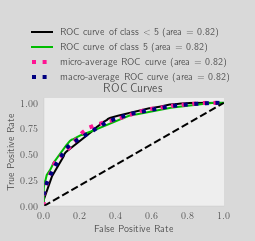

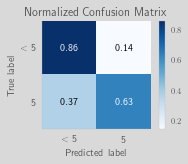

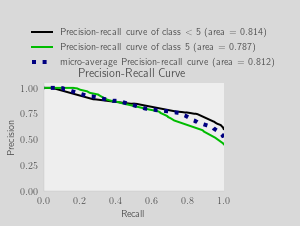

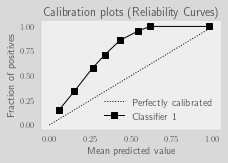

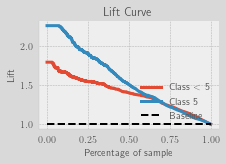

In [66]:
with plt.style.context("rapport"):
    measure("ada", *traintest_binary, lambda: AdaBoostClassifier(n_estimators=20, learning_rate=0.1))

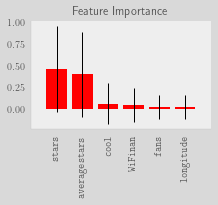

In [97]:
with plt.style.context("rapport"):
    sklplt.estimators.plot_feature_importances(clf, feature_names=names, x_tick_rotation=90,
                                              max_num_features=6)
    savefig("ada_feature_importance")

## Combined

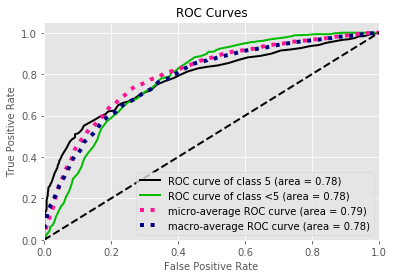

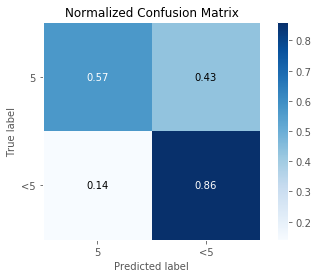

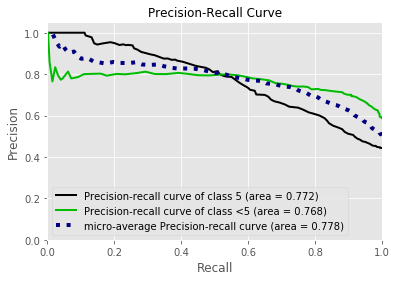

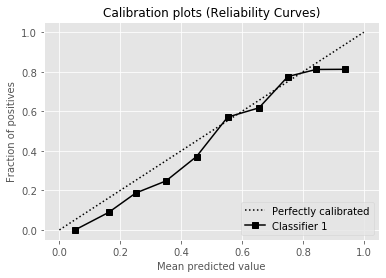

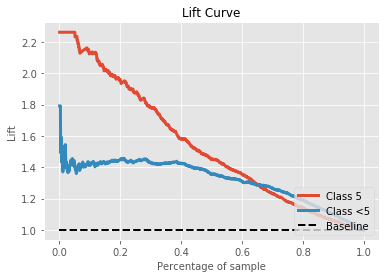

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df.drop(columns=['rating']))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

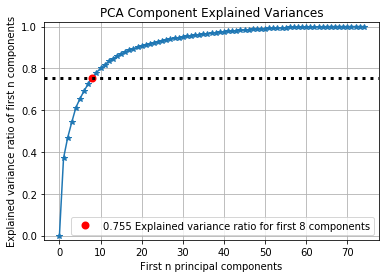

In [14]:
sklplt.decomposition.plot_pca_component_variance(pca)

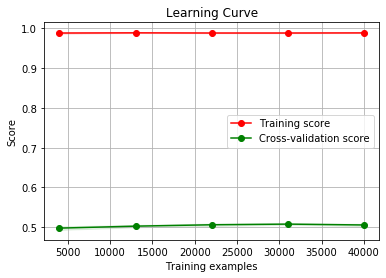

In [35]:
rf = RandomForestClassifier(n_estimators=10)
D = df[:50000]
sklplt.estimators.plot_learning_curve(rf, D.drop(columns=['rating']), D['rating'],
                                     scoring="f1_micro")

In [29]:
from sklearn import metrics
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

Want to compare
- Logistic regression
 - L1, L2
- Decision Trees
- Random forests
 - Vary depth and n_estimators
- Extremely random forests
- AdaBoost
- Neural Nets

Apply each to
- Binary
- Multiclass
- Trial

Decompose
- Trees

Try imbalanced learning

In [199]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from ensemble import Ensemble

D = df[:10000]
X = D.drop(columns=['rating'])
y = D['rating'] >= 5.0
ensemble = Ensemble(X, y, num_members=50)
hyperparameters = [1, 3, 5, 8, 10, 15, 20, 25, 30, 35, 50]
hyperparameters = [None] + list(range(1, 20))
ensemble.run(lambda x: RandomForestClassifier(n_estimators=10, max_depth=x), hyperparameters)

(20, 50)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f35a3b05670>)

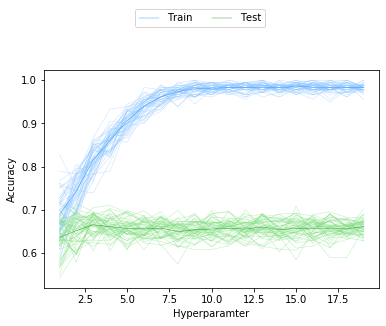

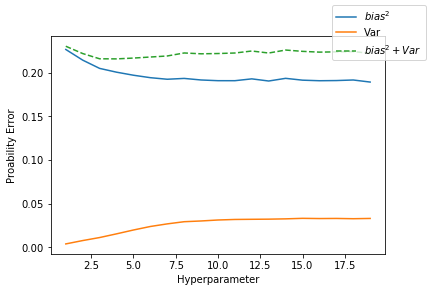

In [200]:
ensemble.plot_train_test()
ensemble.plot_decomposition()

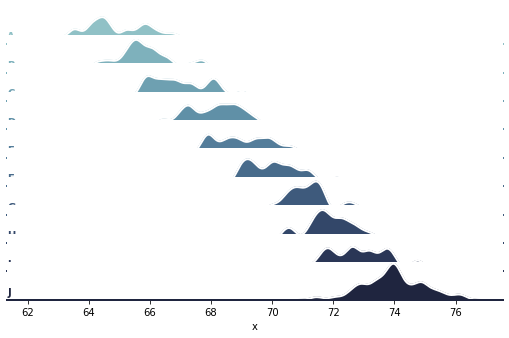

In [12]:
# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)